## frequency domain feature from : https://www.kaggle.com/amanooo/ingv-volcanic-basic-solution-stft

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from tqdm import tqdm
import gc
import pickle
import scipy
import scipy.signal

In [2]:
train = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train.csv")
sample_submission = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/sample_submission.csv")

In [3]:
print(train.shape)
train.head()

(4431, 2)


,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [4]:
train.isna().sum(axis=0).sum()

0

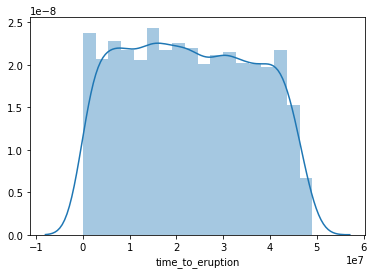

In [5]:
sns.distplot(train['time_to_eruption'])

In [6]:
sample_submission.head()

,segment_id,time_to_eruption
0,1000213997,0
1,100023368,0
2,1000488999,0
3,1001028887,0
4,1001857862,0


### time domain feature

In [7]:
# generate feature
# collect mean / std / 5 / 10 / 20 / 40 percentile / min / max / +5000 / +10000 / +20000 self-corr
def generate_feature_timedomain():
    
    def helper(path):
        data = []
        for file in tqdm(os.listdir(path)):
            tmp = []
            file_path = os.path.join(path, file)
            d = pd.read_csv(file_path)
            tmp.append(eval(file[:-4]))
            # mean
            tmp += d.mean(axis=0).values.astype('float32').tolist()
            # std
            tmp += d.std(axis=0).values.astype('float32').tolist()
            # min
            tmp += d.min(axis=0).values.astype('float32').tolist()
            # max
            tmp += d.max(axis=0).values.astype('float32').tolist()
            # 5 percentile
            tmp += d.quantile(0.05, axis=0).values.astype('float32').tolist()
            # 10 percentile
            tmp += d.quantile(0.1, axis=0).values.astype('float32').tolist()
            # 20 percentile
            tmp += d.quantile(0.2, axis=0).values.astype('float32').tolist()
            # 40 percentile
            tmp += d.quantile(0.4, axis=0).values.astype('float32').tolist()
            # 60 percentile
            tmp += d.quantile(0.6, axis=0).values.astype('float32').tolist()
            # 80 percentile
            tmp += d.quantile(0.8, axis=0).values.astype('float32').tolist()
            # shift
            for col in d:
                d[col+'_5000'] = d[col].shift(5000)
                d[col+'_10000'] = d[col].shift(10000)
                d[col+'_20000'] = d[col].shift(20000)
                d[col+'_30000'] = d[col].shift(30000)
                
            # +5000 / +10000 / +20000 / +30000 self-corr
            for col in d.columns[:10]:
                col1 = col+'_5000'
                col2 = col+'_10000'
                col3 = col+'_20000'
                col4 = col+'_30000'
                tmp1 = d.loc[:, [col, col1]].dropna()
                tmp2 = d.loc[:, [col, col2]].dropna()
                tmp3 = d.loc[:, [col, col3]].dropna()
                tmp4 = d.loc[:, [col, col4]].dropna()
                tmp += [tmp1[col].corr(tmp1[col1]), 
                        tmp2[col].corr(tmp2[col2]), 
                        tmp3[col].corr(tmp3[col3]),
                        tmp4[col].corr(tmp4[col4])]
                
            data.append(tmp)
        return data
                   
    print('train_part: ')
    train_part_fea = helper('../input/predict-volcanic-eruptions-ingv-oe/train')
    print('test_part: ')
    test_part_fea = helper('../input/predict-volcanic-eruptions-ingv-oe/test')
    
    return train_part_fea, test_part_fea

### frequency domain feature

In [8]:
def generate_feature_freq_domain():
    # STFT
    fs = 100
    n = 256
    N = 60001
    max_f = 20
    delta_f = fs / n
    delta_t = n / fs / 2
    
    def helper(fs, n, N, max_f, delta_f, path):
        data = []
        for file in tqdm(os.listdir(path)):
            tmp = []
            file_path = os.path.join(path, file)
            d = pd.read_csv(file_path)
            tmp.append(eval(file[:-4]))
            
            for i in range(d.shape[1]):
                if d.iloc[:, i].isna().sum() > 1000:
                    tmp += [np.nan] * 7 * 65
                    tmp += [np.nan] * 10
                else:
                    # STFT
                    f, t, Z = scipy.signal.stft(d.iloc[:, i].fillna(0).values, fs = fs, window = 'hann', nperseg = n)
                    f = f[:round(max_f/delta_f)+1]
                    
                    Z_half = np.abs(Z[:round(Z.shape[0]//2)+1]).T
                    tmp += Z_half.min(axis=0).astype('float32').tolist()
                    tmp += Z_half.max(axis=0).astype('float32').tolist()
                    tmp += Z_half.std(axis=0).astype('float32').tolist()
                    tmp += Z_half.mean(axis=0).astype('float32').tolist()
                    tmp += np.quantile(Z_half, 0.25, axis=0).astype('float32').tolist()
                    tmp += np.quantile(Z_half, 0.5, axis=0).astype('float32').tolist()
                    tmp += np.quantile(Z_half, 0.75, axis=0).astype('float32').tolist()
                    
                    Z = np.abs(Z[:round(max_f/delta_f)+1]).T    # ～max_f, row:time,col:freq

                    th = Z.mean() * 1     ##########
                    Z_pow = Z.copy()
                    Z_pow[Z < th] = 0
                    Z_num = Z_pow.copy()
                    Z_num[Z >= th] = 1

                    Z_pow_sum = Z_pow.sum(axis = 0)
                    Z_num_sum = Z_num.sum(axis = 0)

                    A_pow = Z_pow_sum[round(10/delta_f):].sum()
                    A_num = Z_num_sum[round(10/delta_f):].sum()
                    BH_pow = Z_pow_sum[round(5/delta_f):round(8/delta_f)].sum()
                    BH_num = Z_num_sum[round(5/delta_f):round(8/delta_f)].sum()
                    BL_pow = Z_pow_sum[round(1.5/delta_f):round(2.5/delta_f)].sum()
                    BL_num = Z_num_sum[round(1.5/delta_f):round(2.5/delta_f)].sum()
                    C_pow = Z_pow_sum[round(0.6/delta_f):round(1.2/delta_f)].sum()
                    C_num = Z_num_sum[round(0.6/delta_f):round(1.2/delta_f)].sum()
                    D_pow = Z_pow_sum[round(2/delta_f):round(4/delta_f)].sum()
                    D_num = Z_num_sum[round(2/delta_f):round(4/delta_f)].sum()
                    tmp += [A_pow, A_num, BH_pow, BH_num, BL_pow, BL_num, C_pow, C_num, D_pow, D_num]
            data.append(tmp)
        return data
    
    print('train_part: ')
    train_part_fea = helper(fs, n, N, max_f, delta_f, path='../input/predict-volcanic-eruptions-ingv-oe/train')
    print('test_part: ')
    test_part_fea = helper(fs, n, N, max_f, delta_f, path='../input/predict-volcanic-eruptions-ingv-oe/test')
    
    return train_part_fea, test_part_fea

In [9]:
train_part_fea, test_part_fea = generate_feature_timedomain()

  0%|          | 0/4431 [00:00<?, ?it/s]

train_part: 


  0%|          | 0/4520 [00:00<?, ?it/s]

test_part: 


100%|██████████| 4520/4520 [28:28<00:00,  2.65it/s]


In [10]:
with open('train_part_fea_time_domain.pkl', 'wb') as f:
    pickle.dump(train_part_fea, f)
    
with open('test_part_fea_time_domain.pkl', 'wb') as f:
    pickle.dump(test_part_fea, f)

In [11]:
train_part_fea_freq, test_part_fea_freq = generate_feature_freq_domain()

  0%|          | 0/4431 [00:00<?, ?it/s]

train_part: 


  0%|          | 0/4520 [00:00<?, ?it/s]

test_part: 


100%|██████████| 4520/4520 [12:25<00:00,  6.07it/s]


In [12]:
with open('train_part_fea_freq_domain.pkl', 'wb') as f:
    pickle.dump(train_part_fea_freq, f)
    
with open('test_part_fea_freq_domain.pkl', 'wb') as f:
    pickle.dump(test_part_fea_freq, f)

***MODEL***

In [13]:
#train_part_fea = pd.read_pickle('../input/ingv-eda-basemodel/train_part_fea.pkl')
#test_part_fea = pd.read_pickle('../input/ingv-eda-basemodel/test_part_fea.pkl')

In [14]:
base_colname = ['sensor_'+str(i) for i in range(1, 11)]
fea_colname = ['segment_id'] + [j + '_mean' for j in base_colname] + [j + '_std' for j in base_colname] + \
                [j + '_min' for j in base_colname] + [j + '_max' for j in base_colname] + \
                    [j + '_5_quant' for j in base_colname] + [j + '_10_quant' for j in base_colname] + \
                        [j + '_20_quant' for j in base_colname] + [j + '_40_quant' for j in base_colname] + \
                        [j + '_60_quant' for j in base_colname] + [j + '_80_quant' for j in base_colname] + \
                    [j + i for j in base_colname for i in ['_5000_self_corr', '_10000_self_corr', 
                                                           '_20000_self_corr', '_30000_self_corr']]

train = pd.merge(train, pd.DataFrame(train_part_fea, columns=fea_colname), on='segment_id', how='left')
sample_submission = pd.merge(sample_submission, pd.DataFrame(test_part_fea, columns=fea_colname), on='segment_id', how='left')

In [15]:
fea_freq_colname = ['segment_id']
for i in base_colname:
    for j in range(65):
        for s in ['min','max', 'std', 'mean', '25_quant', '50_quant', '75_quant']:
            fea_freq_colname.append(i+'_freq'+str(j)+'_'+s)
    fea_freq_colname.extend([i + ss for ss in ['_A_pow', '_A_num', '_BH_pow', '_BH_num', '_BL_pow', 
                                               '_BL_num', '_C_pow', '_C_num', '_D_pow', '_D_num']])

train = pd.merge(train, pd.DataFrame(train_part_fea_freq, columns=fea_freq_colname), on='segment_id', how='left')
sample_submission = pd.merge(sample_submission, pd.DataFrame(test_part_fea_freq, 
                                                             columns=fea_freq_colname), on='segment_id', how='left')

In [16]:
train.to_pickle('train.pkl')
sample_submission.to_pickle('test.pkl')

In [17]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['segment_id', 'time_to_eruption'], axis=1).values, 
                                                    train['time_to_eruption'].values, 
                                                    test_size=0.25, random_state=42)

In [18]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, y_val, reference=train_data,)

#params = {'objective': 'mae', 
#          'num_iterations': ,
#          'learning_rate': , 
#          'num_leaves': ,
#          'seed': ,
#          'metric': 'mae'}

params = { 'num_leaves': 85,
          'n_estimators': 1000,
    'min_data_in_leaf': 10, 
    'objective':'mae',
    'max_depth': -1,
    'learning_rate': 0.01,
    'max_bins': 2048,
    "boosting": "gbdt",
    "feature_fraction": 0.91,
    "bagging_freq": 1,
    "bagging_fraction": 0.91,
    "bagging_seed": 42,
    "metric": 'mae',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": -1,
    "random_state": 42}

model = lgb.train(params=params, train_set=train_data, valid_sets=[train_data, val_data], valid_names=['train', 'val'], 
                  early_stopping_rounds=50)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's l1: 1.14291e+07	val's l1: 1.18386e+07
Training until validation scores don't improve for 50 rounds
[2]	train's l1: 1.13227e+07	val's l1: 1.17395e+07
[3]	train's l1: 1.12192e+07	val's l1: 1.1645e+07
[4]	train's l1: 1.11151e+07	val's l1: 1.15476e+07
[5]	train's l1: 1.10126e+07	val's l1: 1.14521e+07
[6]	train's l1: 1.09108e+07	val's l1: 1.13592e+07
[7]	train's l1: 1.08093e+07	val's l1: 1.12659e+07
[8]	train's l1: 1.07102e+07	val's l1: 1.11707e+07
[9]	train's l1: 1.06104e+07	val's l1: 1.10785e+07
[10]	train's l1: 1.05149e+07	val's l1: 1.09913e+07
[11]	train's l1: 1.04213e+07	val's l1: 1.09074e+07
[12]	train's l1: 1.03233e+07	val's l1: 1.08143e+07
[13]	train's l1: 1.02316e+07	val's l1: 1.0731e+07
[14]	train's l1: 1.01392e+07	val's l1: 1.06464e+07
[15]	train's l1: 1.00482e+07	val's l1: 1.05605e+07
[16]	train's l1: 9.95832e+06	val's l1: 1.04785e+07
[17]	train's l1: 9.8697e+06	val's l1: 1.04003e+07
[18]	train's l1: 9.77781e+06	val's l1: 1.03152e+07
[19]	train's l1: 9.68912e+06	val'

## predict

In [19]:
submission = pd.DataFrame({'segment_id': sample_submission['segment_id'].values, 
    'time_to_eruption': model.predict(sample_submission.iloc[:, 2:].values)})
submission.to_csv('submission.csv', index=False)